In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import random

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
# helper functions
chrs = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chrs)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [55]:
block_size = 8
def build(words) :
    X = []
    Y = []
    for w in words :
        context = [0]*block_size
        for i, c in enumerate(w + '.') :
            ix = stoi[c]
            l = [itos[cont] for cont in context]
            X.append(context)
            Y.append(ix)
    #         print(''.join(l), '-->', c)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

# splitting into train and test(10%)
random.shuffle(words)
n = int(0.1*len(words))
Xtest, Ytest = build(words[:n])
Xtr, Ytr = build(words[n:])
Xtr.shape, Ytr.shape

(torch.Size([205435, 8]), torch.Size([205435]))

In [93]:
class Linear :
    def __init__(self, fanin, fanout, bias=True) :
        self.w = torch.randn((fanin, fanout), generator=g) / fanin**0.5 # the division preserves std, also implemented in pytorch
        self.b = torch.randn((fanout,)) if bias else None
    def __call__(self, x) :
        self.out = x @ self.w
        if self.b is not None:
            self.out += self.b
        return self.out
    def parameters(self) :
        return [self.w] + ([self.b] if self.b is not None else [])
    
class BatchNorm1d :
    def __init__(self, dim, eps=1e-5, momentum=0.1) :
        self.eps = eps
        self.momentum = momentum
        self.training = True # since batch norm internals work differently during training and inference
        self.gamma = torch.ones(dim) # batch norm gain
        self.beta = torch.zeros(dim) # batch norm bias
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x) :
        if self.training :
            if x.ndim==2 : # now takes 3 dimensional input as well
                dim = 0
            elif x.ndim==3 :
                dim = (0,1)
            mean = x.mean(dim, keepdims=True)
            var = x.var(dim, keepdims=True)
        else :
            mean = self.running_mean
            var = self.running_var
        self.out = self.gamma*(x - mean) / torch.sqrt(var+self.eps) + self.beta
        
        if self.training :
            with torch.no_grad() :
                self.running_mean = self.running_mean*(1-self.momentum) + mean*self.momentum
                self.running_var = self.running_var*(1-self.momentum) + var*self.momentum
        return self.out
    def parameters(self) :
        return [self.gamma, self.beta]
    
class Tanh :
    def __call__(self, x) :
        self.out = x.tanh()
        return self.out
    def parameters(self) :
        return []
    
class Embedding :
    def __init__(self, num_embeddings, embedding_dim) :
        self.w = torch.randn((num_embeddings, embedding_dim))
    def __call__(self, x) :
        self.out = self.w[x] 
        return self.out
    def parameters(self) :
        return [self.w]
    
class Flatten : # adding the multi-flatten functionality as well
    def __init__(self, n=3) :
        self.n = n
    def __call__(self, x) :
        B, T, C = x.shape
        x = x.view(B, -1, C*self.n)
        if x.shape[1]==1 :
            x = x.squeeze(1) # removing the spurious dimension
        self.out = x
        return self.out
    def parameters(self) :
        return []
    
class Sequential :
    def __init__(self, layers) :
        self.layers = layers
    def __call__(self, x) :
        for layer in self.layers :
            x = layer(x)
#             print(layer,__class__.__name__, ' : ', x.shape)
        self.out = x
        return self.out
    def parameters(self) :
        return [p for layer in self.layers for p in layer.parameters()]

In [94]:
embed_shape = 10
nhidden = 68 # 200
# block_size = 8
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# C = torch.randn((27,embed_shape), generator=g) # embedding map
model = Sequential([
    Embedding(27, embed_shape), Flatten(2),
    Linear(2*embed_shape, nhidden, bias=False), BatchNorm1d(nhidden), Tanh(), Flatten(2),
    Linear(2*nhidden, nhidden, bias=False), BatchNorm1d(nhidden), Tanh(), Flatten(2),
    Linear(2*nhidden, nhidden, bias=False), BatchNorm1d(nhidden), Tanh(),
    Linear(nhidden, 27)
]) # layers of the network

with torch.no_grad() :
    model.layers[-1].w *= 0.1 # lowering the confidence in the final layer
    for layer in layers[:-1] :
        if isinstance(layer, Linear) :
            model.layer.w *= (5/3) # gain for tanh
params = model.parameters()
for p in params :
    p.requires_grad = True

In [95]:
lossi = []
ud = []
for i in range(200001) : # of epochs
    # taking batches 
    ix = torch.randint(0, Xtr.shape[0], (32,), generator=g)
    
    logits = model(Xtr[ix])
#     print(x.shape)
#     for layer in layers :
#         print(f'class : {layer.__class__}', end=', ')
#         x = layer(x) # forward pass
#         print(f'shape : {x.shape}')
    
    # logits = third.softmax(dim=1)
    # nll = -logits[torch.arange(10), Y[:10]].log().mean()
    nll = F.cross_entropy(logits, Ytr[ix])
    lossi.append(nll)
    for layer in layers :
        layer.out.retain_grad() # retains the grad to be able to plot later
# usually non-leaf params do not have their .grad attrbutes populated, since they are almost never required
# they just pass grads downwards
# to be able to access these later, we need retain_grad
    
    lr = 0.1 if i<100000 else 0.01
    for p in params :
        p.grad = None
    nll.backward()
    for p in params :
#         print(p.shape)
        p.data -= lr*p.grad
    if i%10000==0 :
        print(f'step: {i:5d} / {200000} loss {nll:.7f}')
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in params])
#     if i>1000 : break
#     break

step:     0 / 200000 loss 3.3265309
step: 10000 / 200000 loss 2.2113678
step: 20000 / 200000 loss 1.6953472
step: 30000 / 200000 loss 2.1423116
step: 40000 / 200000 loss 2.3081400
step: 50000 / 200000 loss 3.0312290
step: 60000 / 200000 loss 2.1745002
step: 70000 / 200000 loss 2.3692713
step: 80000 / 200000 loss 2.0714142
step: 90000 / 200000 loss 1.8538692
step: 100000 / 200000 loss 2.2627044
step: 110000 / 200000 loss 1.8104047
step: 120000 / 200000 loss 1.9797316
step: 130000 / 200000 loss 2.1659539
step: 140000 / 200000 loss 2.4018681
step: 150000 / 200000 loss 1.9069350
step: 160000 / 200000 loss 1.9714333
step: 170000 / 200000 loss 2.1993754
step: 180000 / 200000 loss 1.7353581
step: 190000 / 200000 loss 2.3414338
step: 200000 / 200000 loss 2.0226262


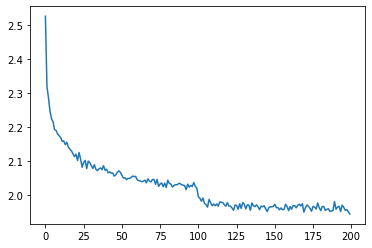

In [107]:
temp = torch.tensor([x.detach().item() for x in lossi])
plt.plot(temp[:-1].view(-1,1000).mean(1))

In [108]:
# Final train and test losses
for layer in model.layers :
    if isinstance(layer, BatchNorm1d) :
        layer.training = False
for p in model.parameters() :
    p.requires_grad = False
        
logits = model(Xtr)
nll = F.cross_entropy(logits, Ytr)
print(f'Train : {nll}')

logits = model(Xtest)
nll = F.cross_entropy(logits, Ytest)
print(f'Test : {nll}')

Train : 1.9313099384307861
Test : 2.021084785461426


In [111]:
# inference

for p in model.parameters() :
    p.requires_grad = False
for layer in model.layers :
    if isinstance(layer, BatchNorm1d) :
        layer.training = False
for _ in range(10) :
    context = [0]*block_size
    while True :
        logits = model(torch.tensor(context).view(1,-1))
        probs = logits.softmax(dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
        if ix==0 : break
        print(itos[ix], end='')
        context = context[1:] + [ix]
    print()

suli
tazion
sandida
marbellah
adyron
dariyah
garlyn
amaysra
abidlea
isyla


In [110]:
# the losses can be beaten by appropriate hyperparameter tuning
# The archotecture follows Wavenet
# https://arxiv.org/abs/1609.03499